In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
MAXIMUM_Q_VALUE = 0.01

In [3]:
psms_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli.percolator.target.psms.txt', sep='\t')
psms_df = psms_df[psms_df['percolator q-value'] <= MAXIMUM_Q_VALUE]

In [4]:
psms_df[psms_df.file_idx == 0].sort_values(by='scan').head()

,file_idx,scan,charge,spectrum precursor m/z,spectrum neutral mass,peptide mass,percolator score,percolator q-value,percolator PEP,total matches/spectrum,sequence,protein id,flanking aa
22071,0,3,2,871.9112,1741.8078,1742.8120,1.074627,0.000003,1.274665e-09,122855,AMGIMNSFVNDIFER,"sp|Q5QNW6|H2B2F_HUMAN,sp|Q99879|H2B1M_HUMAN,sp...",KI
380397,0,4,2,901.9452,1801.8758,1802.8799,0.499210,0.000003,5.460350e-05,122855,GITINTSHVEYDTPTR,"sp|P0CE48|EFTU2_ECOLI,sp|P0CE47|EFTU1_ECOLI",RH
18633,0,5,3,801.0837,2400.2291,2401.2336,1.095587,0.000003,8.642908e-10,122855,ANDAAGDGTTTATVLAQAIITEGLK,sp|P0A6F5|CH60_ECOLI,KA
446,0,6,2,1093.0845,2184.1545,2128.1350,1.488718,0.000003,5.911491e-13,122855,IPISGIAGDQQAALFGQLCVK,sp|P0A6F3|GLPK_ECOLI,RE
191655,0,7,2,965.5864,1929.1583,1930.1615,0.722457,0.000003,8.721569e-07,122855,VTIAQGGVLPNIQAVLLPK,"sp|Q99878|H2A1J_HUMAN,sp|Q9BTM1|H2AJ_HUMAN,sp|...",KK


In [5]:
mapping = []
with open('/Users/darylwilding-mcbride/Downloads/percolator-stdout.log') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('INFO: Assigning index'):
            splits = line.split(' ')
            percolator_index = int(splits[3])
            comet_filename = splits[5]
            base_name = comet_filename.split('/')[-1].split('.')[0]
            mapping.append((percolator_index, base_name))

In [6]:
mapping

[(0, '190719_Hela_Ecoli_1to3_06'),
 (1, '190719_Hela_Ecoli_1to1_07'),
 (2, '190719_Hela_Ecoli_1to3_07'),
 (3, '190719_Hela_Ecoli_1to1_09'),
 (4, '190719_Hela_Ecoli_1to3_05'),
 (5, '190719_Hela_Ecoli_1to3_09'),
 (6, '190719_Hela_Ecoli_1to1_04'),
 (7, '190719_Hela_Ecoli_1to3_08'),
 (8, '190719_Hela_Ecoli_1to3_04'),
 (9, '190719_Hela_Ecoli_1to3_10'),
 (10, '190719_Hela_Ecoli_1to1_03'),
 (11, '190719_Hela_Ecoli_1to1_10'),
 (12, '190719_Hela_Ecoli_1to1_06'),
 (13, '190719_Hela_Ecoli_1to3_03'),
 (14, '190719_Hela_Ecoli_1to3_01'),
 (15, '190719_Hela_Ecoli_1to3_02'),
 (16, '190719_Hela_Ecoli_1to1_01'),
 (17, '190719_Hela_Ecoli_1to1_02'),
 (18, '190719_Hela_Ecoli_1to1_08'),
 (19, '190719_Hela_Ecoli_1to1_05')]

In [7]:
# sequence_counts = []
# for group_name,group_df in psms_df.groupby('sequence'):
#     print(group_name, group_df.file_idx.value_counts().to_frame())
    

In [8]:
features_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli/pkl/190719_Hela_Ecoli_1to3_06-features.pkl')
features_df.drop(['candidate_phr_error','envelope','mono_adjusted','original_phr','original_phr_error','precursor_id','rt_curve_fit','rt_lower','rt_upper','scan_curve_fit','scan_lower','scan_upper'], axis=1, inplace=True)


In [9]:
features_df.head()

,charge,feature_id,intensity,intensity_full_rt_extent,monoisotopic_mz,rt_apex,scan_apex
0,2,1,16177434.0,15779061,966.089957,1059.62,152.06
1,2,2,12349904.0,9396591,939.437537,1018.38,143.85
2,2,3,10968797.0,7373639,872.414808,1071.22,360.74
3,2,4,10678154.0,7011464,902.448836,494.21,188.76
4,3,5,10145693.0,4308726,801.419409,1079.44,481.90


In [10]:
df_l = []
for m in mapping:
    idx = m[0]
    filename = m[1]
    df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli/pkl/{}-features.pkl'.format(filename))
    df['percolator_idx'] = idx
    df['batch'] = filename.split('_')[3]
    df_l.append(df)
# make a single df from the list of dfs
features_df = pd.concat(df_l, axis=0)

In [11]:
percolator_df = pd.merge(psms_df, features_df, how='left', left_on=['file_idx','scan'], right_on=['percolator_idx','feature_id'])
percolator_df['human'] = percolator_df['protein id'].str.contains('HUMAN')

In [12]:
len(percolator_df)

619988

In [13]:
percolator_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'candidate_phr_error',
       'charge_y', 'envelope', 'feature_id', 'intensity',
       'intensity_full_rt_extent', 'mono_adjusted', 'monoisotopic_mz',
       'original_phr', 'original_phr_error', 'precursor_id', 'rt_apex',
       'rt_curve_fit', 'rt_lower', 'rt_upper', 'scan_apex', 'scan_curve_fit',
       'scan_lower', 'scan_upper', 'percolator_idx', 'batch', 'human'],
      dtype='object')

In [14]:
sequences_l = []
for group_name,group_df in percolator_df.groupby(['file_idx','sequence','charge_x'], as_index=False):
    t = (group_df.iloc[0].batch,)
    t += group_name
    t += (group_df.intensity.max(),group_df.iloc[0].human,len(group_df))
    sequences_l.append(t)

In [15]:
sequences_df = pd.DataFrame(sequences_l, columns=['batch','file_idx','sequence','charge','intensity','human','count_in_file'])

In [16]:
sequences_df.head()

,batch,file_idx,sequence,charge,intensity,human,count_in_file
0,1to3,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,162746.0,True,2
1,1to3,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,58153.0,True,3
2,1to3,0,AAAAAWEEPSSGNGTAR,2,258410.0,True,1
3,1to3,0,AAAAFVLANENNIALFK,2,53538.0,True,1
4,1to3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,203979.0,False,1


In [17]:
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= 5) and (len(sequence_in_1to3_df) >= 5):
        average_intensity_in_1to1 = sequence_in_1to1_df.intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.intensity.mean()
        human = group_df.iloc[0].human
        t = group_name
        t += (average_intensity_in_1to1, average_intensity_in_1to3, human)
        sequence_occurences_in_batch.append(t)

In [18]:
sequence_occurences_in_batch[:2]

[('AAAAAAAAVPSAGPAGPAPTSAAGR', 2, 70306.0, 56008.2, True),
 ('AAAAATVVPPMVGGPPFVGPVGFGPGDR', 3, 50455.833333333336, 55671.0, True)]

In [19]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [20]:
sequence_occurences_in_batch_df.head()

,sequence,charge,intensity_1to1,intensity_1to3,human
0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,70306.000000,56008.200000,True
1,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,50455.833333,55671.000000,True
2,AAAAAWEEPSSGNGTAR,2,367740.200000,284638.900000,True
3,AAAEDVNVTFEDQQK,2,194934.125000,78582.222222,True
4,AAAEELQEAAGAGDGATENGVQPPK,2,80061.100000,72475.000000,True


In [23]:
sequence_occurences_in_batch_df['intensity_ratio'] = np.log(sequence_occurences_in_batch_df.intensity_1to1 / sequence_occurences_in_batch_df.intensity_1to3)

In [24]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

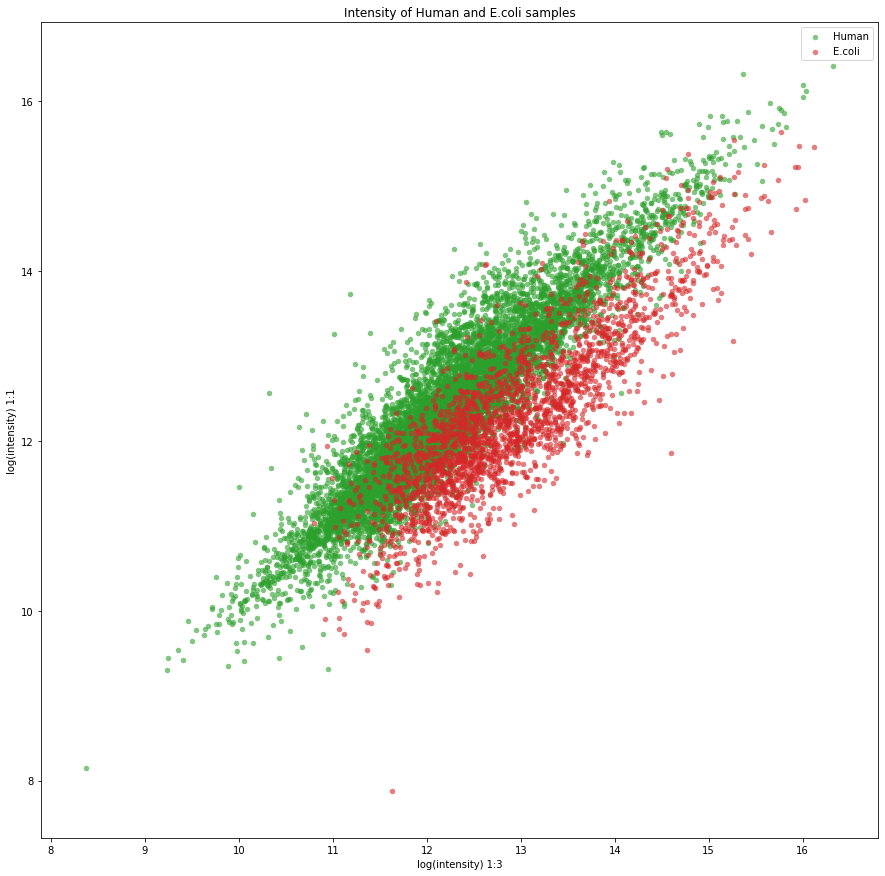

In [25]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Intensity of Human and E.coli samples')

ax.scatter(np.log(human_df.intensity_1to3), np.log(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human")
ax.scatter(np.log(ecoli_df.intensity_1to3), np.log(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli")

plt.legend(loc='best')
plt.xlabel('log(intensity) 1:3')
plt.ylabel('log(intensity) 1:1')

plt.show()

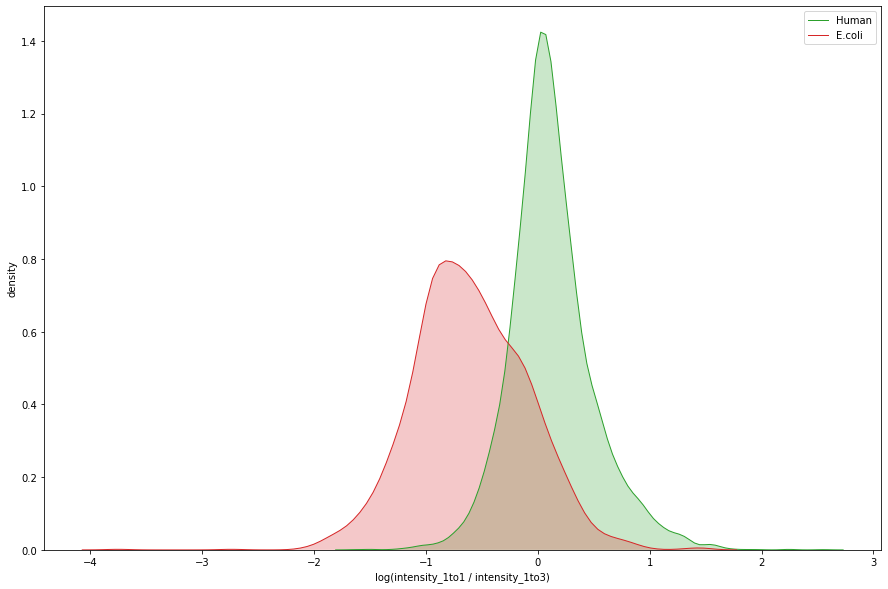

In [41]:
import seaborn as sns
plt.figure(figsize=(15, 10))

ax = sns.distplot(human_df['intensity_ratio'], hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(ecoli_df['intensity_ratio'], hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

_ = ax.set(xlabel='log(intensity_1to1 / intensity_1to3)', ylabel='density')
